# **Chapter 7. Secular Perturbations**

## **Action by Daniel Niño-Villegas, University of Antioquia**

In this notebook we will present part of the theoretical background of the chapter devoted to *Secular Perturbations* and some mathematical and numerical results which are interested for the theory.

For details on the theory please refer directly to the book:

> Murray, C. D., & Dermott, S. F. (1999). Solar system dynamics. Cambridge university press.

## Preliminaries

### Prerrequisites

In [ ]:
#!pip install -q rebound
#!pip install -q Fraction
#!pip install -q ipywidgets

### Other libraries

In [28]:
#Global packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
import rebound as rb
import celluloid as cell
from secular import *

#Specific modules and routines
from tqdm import tqdm
from ipywidgets import interact, widgets, fixed
from fractions import Fraction
from IPython.core.display import HTML

### Useful constants

In [29]:
deg = np.pi/180
rad = 1/deg

### Plots aesthetics

In [30]:
%matplotlib nbagg
#If you run this in Colab use
#%matplotlib inline

plt.rcParams['text.usetex'] = True
#If you don't have installed latex
#font for matplotlib, set this parameter
#to false. If you run this in Colab, set
#this parameter to false.

## **Section 7.2 Secular Perturbations for Two Planets**

### Experiment: Laplace coefficients study (7.1)

<p align="justify"> In the previous section we introduced the computation of the Laplace coefficients and their derivatives (up to second order), who are completely essential in the development of perturbation theory. This functions are until now completely "dark" in a sense that we don't know how they behave or even how their derivatives behave. So, we´ll now show an interactive plot of $b_{s}^{(j)}(\alpha)$, $D \, b_{s}^{(j)}(\alpha)$ and $D^2 \, b_{s}^{(j)}(\alpha)$ where you can modify the parameters $s$ and $j$ to see how the coefficents change: </p>

In [33]:
def blap_plot(s,j):
    a = np.linspace(0, 0.9, 1000)
    b = np.array([blap(x, s, j) for x in a])
    db = np.array([blap_dot(x, s, j) for x in a])
    ddb = np.array([blap_ddot(x, s, j) for x in a])
    
    j = int(j)
    s = str(Fraction(s).numerator) + '/' + str(Fraction(s).denominator)
    ss = fr'$s = {s}$' + r'$\hspace{20 pt}$' fr'$j = {j}$'
    
    plt.close()
    fig, axs = plt.subplots(3, 1, figsize=(4,6), sharex=True, dpi=110)
    axs[0].set_title(ss, fontsize=15)
    axs[0].set_ylabel(r'$b_{s}^{(j)}(\alpha)$', fontsize=17)
    axs[0].plot(a, b, 'k-')
    axs[1].set_xlabel(r'$\alpha$', fontsize=15)
    axs[1].set_ylabel(r'$D \, b_{s}^{(j)}(\alpha)$', fontsize=15)
    axs[1].plot(a, db, 'k-')
    axs[2].set_xlabel(r'$\alpha$', fontsize=15)
    axs[2].set_ylabel(r'$D^2 \, b_{s}^{(j)}(\alpha)$', fontsize=15)
    axs[2].plot(a, ddb, 'k-')
    fig.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.show()

In [34]:
opciones = dict(continuous_update=False)
interact(blap_plot,
         s = widgets.FloatSlider(min=0.5, max=5, step=0.5, value=0.5, **opciones),
         j = widgets.FloatSlider(min=0, max=5, step=1, value=0, **opciones))

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='s', max=5.0, min=0.5, step=…

<function __main__.blap_plot(s, j)>

<p align="justify"> An important result of the previous plots is that the Laplace coefficients diverge rapidly near $\alpha = 1$, and so their derivatives. You can also check that if you increase the value of the $s$ parameter, the coefficient is virtually cero for a large number of $\alpha$ values, and diverge much quickly near $\alpha=1$. Be free to combine different parameter values to check all of this for yourself. </p>

### Experiment: excentricity and inclination vectors (7.2)

For the following experiment we'll suppose a system made up with a central body of mass $m_c$ and two orbiting bodies with masses $m_1$ and $m_2$, where $m_1 \ll m_c$ and $m_2 \ll m_c$; for convention we'll take the inner body to be $m_1$ and the outter body to be $m_2$. In the previous notebook we developed the theory for a similar system where $m_1 \ll m_2$, but now we'll describe the motion for two particles ignoring this condition.  Let's write the disturbing function for both bodies like we did before:

Initial conditions:

\begin{equation*}
\mathcal{R}_1 = \frac{G m_2}{a_1} \alpha_{12} \mathcal{R}_{\mathrm{D}}^{(\text{sec})}, \hspace{1 cm} \mathcal{R}_2 = \frac{G m_1}{a_2} \mathcal{R}_{\mathrm{D}}^{(\text{sec})} \tag{1} \label{eq:dist_funcs}
\end{equation*}

Where:

\begin{equation*}
\begin{aligned}
\mathcal{R}_{\mathrm{D}}^{(\mathrm{sec})}= & \frac{1}{8}\left[2 \alpha_{12} D+\alpha_{12}^2 D^2\right] b_{\frac{1}{2}}^{(0)}\left(e_1^2+e_2^2\right)-\frac{1}{2} \alpha_{12} b_{3 / 2}^{(1)}\left(s_1^2+s_2^2\right) \\
& +\frac{1}{4}\left[2-2 \alpha_{12} D-\alpha_{12}^2 D^2\right] b_{\frac{1}{2}}^{(1)} e_1 e_2 \cos \left(\varpi_1-\varpi_2\right) \\
& +\alpha_{12} b_{3 / 2}^{(1)} s_1 s_2 \cos \left(\Omega_1-\Omega_2\right)
\end{aligned} \tag{2} \label{eq:dist_direct1}
\end{equation*}

Note that we've dropped the $\frac{1}{2} b_{\frac{1}{2}}^{(0)}(\alpha)$ term in $\mathcal{R}_{\mathrm{D}}^{(\mathrm{sec})}$ due to the fact that Lagrange's equations for $a_1$ and $a_2$ are proportional to $\frac{\partial \mathcal{R}}{\partial \lambda_j}$, and in a secular regime we won´t consider terms asociated with the mean anomalies. Using the recursion relations for the Laplace coefficients it can be found that:

\begin{equation*}
2 \alpha \frac{\mathrm{d} b_{1 / 2}^{(0)}}{\mathrm{d} \alpha}+\alpha^2 \frac{\mathrm{d}^2 b_{1 / 2}^{(0)}}{\mathrm{d} \alpha^2} = \alpha b_{3/2}^{(1)} \tag{3} \label{eq:lap_1}
\end{equation*}

\begin{equation*}
2 b_{1/2}^{(1)}-2 \alpha \frac{\mathrm{d} b_{1/2}^{(1)}}{\mathrm{d} \alpha}-\alpha^2 \frac{\mathrm{d}^2 b_{1 / 2}^{(1)}}{\mathrm{d} \alpha^2} = -\alpha b_{3/2}^{(2)} \tag{4} \label{eq:lap_2}
\end{equation*}

Plugging \eqref{eq:lap_1} and \eqref{eq_lap_2} in \eqref{eq:dist_direct1} we find that:

\begin{equation*}
\begin{aligned}
\mathcal{R}_{\mathrm{D}}^{(\mathrm{sec})}= & \frac{1}{8}\alpha b_{3 / 2}^{(1)}\left(e_1^2+e_2^2\right)-\frac{1}{2} \alpha_{12} b_{3 / 2}^{(1)}\left(s_1^2+s_2^2\right) \\
& - \frac{1}{4} \alpha b_{3 / 2}^{(2)} e_1 e_2 \cos \left(\varpi_1-\varpi_2\right) \\
& +\alpha_{12} b_{3 / 2}^{(1)} s_1 s_2 \cos \left(\Omega_1-\Omega_2\right)
\end{aligned} \tag{5} \label{eq:dist_direct2}
\end{equation*}

Now we can replace \eqref{eq:dist_direct2} in eqs. \eqref{dist_funcs}:

\begin{equation*}
\begin{aligned}
\mathcal{R}_1 = \frac{G m_2}{a_1} & {\left[\frac{1}{8} \alpha_{12}^2 b_{3 / 2}^{(1)} (e_1^2 + e_2^2)-\frac{1}{8} \alpha_{12}^2 b_{3 / 2}^{(1)} (s_1^2 + s_2^2) \right.} \\
& -\frac{1}{4} \alpha_{12}^2 b_{3 / 2}^{(2)} e_1 e_2 \cos \left(\varpi_1-\varpi_2\right) \\
& \left.+\frac{1}{4} \alpha_{12}^2 b_{3 / 2}^{(1)} I_1 I_2 \cos \left(\Omega_1-\Omega_2\right)\right]
\end{aligned} \tag{6} \label{dist_func1.1}
\end{equation*}

\begin{equation*}
\begin{aligned}
\mathcal{R}_2 = \frac{G m_1}{a_2} & {\left[\frac{1}{8} \alpha_{12} b_{3 / 2}^{(1)} (e_1^2 + e_2^2) - \frac{1}{8} \alpha_{12} b_{3 / 2}^{(1)} (s_1^2 + s_2^2) \right.} \\
& -\frac{1}{4} \alpha_{12} b_{3 / 2}^{(2)} e_1 e_2 \cos \left(\varpi_1-\varpi_2\right) \\
& \left.+\frac{1}{4} \alpha_{12} b_{3 / 2}^{(1)} I_1 I_2 \cos \left(\Omega_1-\Omega_2\right)\right]
\end{aligned} \tag{7} \label{dist_func2.1}
\end{equation*}

With this equations, we can now do a little handling:

\begin{equation*}
\begin{aligned}
\mathcal{R}_1 = \frac{G m_2}{a_1} & {\left[\frac{1}{8} \alpha_{12}^2 b_{3 / 2}^{(1)} e_1^2-\frac{1}{8} \alpha_{12}^2 b_{3 / 2}^{(1)} s_1^2 \right.} \\
& -\frac{1}{4} \alpha_{12}^2 b_{3 / 2}^{(2)} e_1 e_2 \cos \left(\varpi_1-\varpi_2\right) \\
& \left.+\frac{1}{4} \alpha_{12}^2 b_{3 / 2}^{(1)} I_1 I_2 \cos \left(\Omega_1-\Omega_2\right)\right] \\
& +  \underbrace{\frac{G m_2}{a_1} \left[ \frac{1}{8} \alpha_{12}^2 b_{3 / 2}^{(1)} e_2^2 - \frac{1}{8} \alpha_{12}^2 b_{3 / 2}^{(1)} s_2^2 \right]}
\end{aligned} \tag{8} \label{dist_func1.2}
\end{equation*}

\begin{equation*}
\begin{aligned}
\mathcal{R}_2 = \frac{G m_1}{a_2} & {\left[\frac{1}{8} \alpha_{12} b_{3 / 2}^{(1)} e_2^2 - \frac{1}{8} \alpha_{12} b_{3 / 2}^{(1)} s_2^2 \right.} \\
& -\frac{1}{4} \alpha_{12} b_{3 / 2}^{(2)} e_1 e_2 \cos \left(\varpi_1-\varpi_2\right) \\
& \left.+\frac{1}{4} \alpha_{12} b_{3 / 2}^{(1)} I_1 I_2 \cos \left(\Omega_1-\Omega_2\right)\right] \\
& + \underbrace{\frac{G m_1}{a_2} \left[ \frac{1}{8} \alpha_{12} b_{3 / 2}^{(1)} e_1^2 - \frac{1}{8} \alpha_{12} b_{3 / 2}^{(1)} s_1^2 \right]}
\end{aligned} \tag{9} \label{dist_func2.2}
\end{equation*}

You can surely note that the underlined terms will have no effect in the Lagrange's equations because they point to the other particle, so the derivatives of these will be zero. Now we'll use Kepler's third law approximation:

\begin{equation*}
G(m_c + m_1) \approx n_1^2 a_1^3, \hspace{0.5 cm} G(m_c + m_2) \approx n_2^2 a_2^3
\end{equation*}

That yields:

\begin{equation*}
\frac{G}{a_1} = \frac{n_1^2 a_1^2}{m_c+m_1}, \hspace{0.5 cm} \frac{G}{a_2} = \frac{n_2^2 a_2^2}{m_c+m_2} \tag{10} \label{eq:kepler}
\end{equation*}

Replacing \eqref{eq:kepler} in \eqref{dist_func1.2} and \eqref{dist_func2.2}, and assuming that the approximations $s_1 \approx \frac12 I_1$, $s_2 \approx \frac12 I_2$ are valid we get:

\begin{equation*}
\begin{aligned}
\mathcal{R}_1=n_1^2 a_1^2 \frac{m_2}{m_{\mathrm{c}}+m_1} & {\left[\frac{1}{8} \alpha_{12}^2 b_{3 / 2}^{(1)} e_1^2-\frac{1}{8} \alpha_{12}^2 b_{3 / 2}^{(1)} I_1^2\right.} \\
& -\frac{1}{4} \alpha_{12}^2 b_{3 / 2}^{(2)} e_1 e_2 \cos \left(\varpi_1-\varpi_2\right) \\
& \left.+\frac{1}{4} \alpha_{12}^2 b_{3 / 2}^{(1)} I_1 I_2 \cos \left(\Omega_1-\Omega_2\right)\right]
\end{aligned} \tag{11} \label{eq:dist_func1.3}
\end{equation*}

\begin{equation*}
\begin{aligned}
\mathcal{R}_2=n_2^2 a_2^2 \frac{m_1}{m_{\mathrm{c}}+m_2} & {\left[\frac{1}{8} \alpha_{12} b_{3 / 2}^{(1)} e_2^2-\frac{1}{8} \alpha_{12} b_{3 / 2}^{(1)} I_2^2\right.} \\
& -\frac{1}{4} \alpha_{12} b_{3 / 2}^{(2)} e_1 e_2 \cos \left(\varpi_1-\varpi_2\right) \\
& \left.+\frac{1}{4} \alpha_{12} b_{3 / 2}^{(1)} I_1 I_2 \cos \left(\Omega_1-\Omega_2\right)\right]
\end{aligned} \tag{12} \label{eq:dist_func2.3}
\end{equation*}

In [7]:
#Partticle #1
m1 = 1e-4
a1 = 2
e1 = 0.02
pomega1 = 10*deg

#Particle #2
m2 = 1e-4
a2 = 3
e2 = 0.08
pomega2 = 250*deg

#Smulation t=0
sim = rb.Simulation()
sim.units = ('au', 'msun', 'yr')
sim.add(m=1, hash='Sun')
sim.add(m=m1, a=a1, e=e1, pomega=pomega1, hash='Particle #1')
sim.add(m=m2, a=a2, e=e2, pomega=pomega2, hash='Particle #2')
#sim.save('tmp/system.bin')

Orbit plot:

<IPython.core.display.Javascript object>


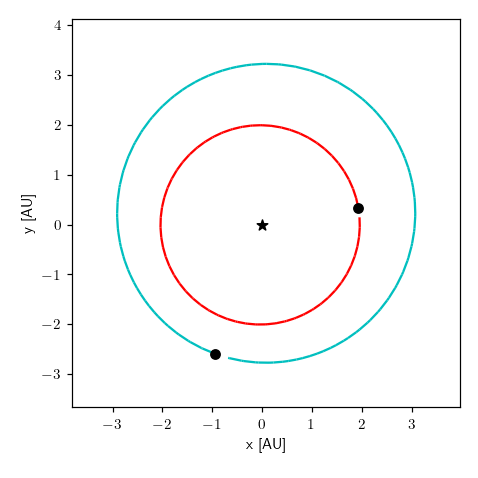

In [8]:
#Orbits plot
fig, ax = rb.OrbitPlot(sim, unitlabel='[AU]', orbit_type='solid', lw=1.5, color=True, figsize=(4,4))
fig.set_dpi(100)
fig.tight_layout()
plt.show()

Orbit periods:

In [9]:
#Orbital periods
P1 = sim.particles['Particle #1'].P
n1 = 2*np.pi/P1
P2 = sim.particles['Particle #2'].P
n2 = 2*np.pi/P2

Integration parameters:

In [10]:
#Integration parameters
sim.dt = P1/100
Nt = 1000
ts = np.linspace(0, 200000, Nt)

Integration:

In [11]:
#Integration
Es = np.zeros((2,Nt,3))
for i,t in enumerate(tqdm(ts)):
    sim.integrate(t)
    sim.move_to_hel()
    orbits = sim.calculate_orbits()
    Es[0][i] = [orbits[0].a,
                orbits[0].e,
                np.mod(orbits[0].pomega,2*np.pi)]
    Es[1][i] = [orbits[1].a,
                orbits[1].e,
                np.mod(orbits[1].pomega,2*np.pi)]

100%|█████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.29it/s]


In [15]:
def vec_orbit_plot(e1, e2, pomega1, pomega2, L, i, Np=1000, s=1.1):
    #Excentricity vectors
    hvec = np.zeros(2)
    kvec = np.zeros(2)
    
    hvec[0] = e1[i]*np.sin(pomega1[i])
    hvec[1] = e2[i]*np.sin(pomega2[i])
    
    kvec[0] = e1[i]*np.cos(pomega1[i])
    kvec[1] = e2[i]*np.cos(pomega2[i])
    
    #Orbits 
    f = np.linspace(0, 2*np.pi, Np)  #True anomaly
    p1 = a1[i]*(1-e1[i]**2)          #Semilatus rectum #1
    p2 = a2[i]*(1-e2[i]**2)          #Semilatus rectum #2
    
    ##Polar ellipse equation #1
    x1 = (p1/(1 + e1[i]*np.cos(f)))*np.cos(f)
    y1 = (p1/(1 + e1[i]*np.cos(f)))*np.sin(f)
    
    ##Rotated coordinates #1
    x1_ = x1*np.cos(pomega1[i]) - y1*np.sin(pomega1[i])
    y1_ = x1*np.sin(pomega1[i]) + y1*np.cos(pomega1[i])
    
    ##Polar ellipse equation #2
    x2 = (p2/(1 + e2[i]*np.cos(f)))*np.cos(f)
    y2 = (p2/(1 + e2[i]*np.cos(f)))*np.sin(f)
    
    ##Rotated coordinates #2
    x2_ = x2*np.cos(pomega2[i]) - y2*np.sin(pomega2[i])
    y2_ = x2*np.sin(pomega2[i]) + y2*np.cos(pomega2[i])
    
    a = max([a1[i],a2[i]])
    e = max([e1[i],e2[i]])
    
    #Complete Plot
    ##Orbits
    axs[0].text(-3.6, 3.3, r'$\varpi_1 =$ %.0f $^{\circ}$'%(pomega1[i]*rad))
    axs[0].text(1.3, 3.3,  r'$\varpi_2 =$ %.0f $^{\circ}$'%(pomega2[i]*rad))
    axs[0].set_xlabel('x [AU]', fontsize=12)
    axs[0].set_ylabel('y [AU]', fontsize=12)
    axs[0].set_xlim((-a*(1+e)*s,a*(1+e)*s))
    axs[0].set_ylim((-a*(1+e)*s,a*(1+e)*s))
    axs[0].plot(x1_, y1_, 'k-', lw=1)
    axs[0].plot(x2_, y2_, 'k-', lw=1)
    axs[0].plot([0],[0], 'y*', ms=5)
    axs[0].arrow(0, 0, a1[i]*(1-e1[i])*np.cos(pomega1[i]), a1[i]*(1-e1[i])*np.sin(pomega1[i]), color='r')
    axs[0].arrow(0, 0, a2[i]*(1-e2[i])*np.cos(pomega2[i]), a2[i]*(1-e2[i])*np.sin(pomega2[i]), color='r')
    axs[0].set_aspect('equal', 'box')
    ##Excentricity Vectors
    axs[1].set_xlim(-s*L,s*L)
    axs[1].set_ylim(-s*L,s*L)
    axs[1].text(1.15*hvec[0], 1.15*hvec[1], r'$\vec{h}$', fontsize=14)
    axs[1].text(1.15*kvec[0], 1.15*kvec[1], r'$\vec{k}$', fontsize=14)
    ####Axis
    axs[1].arrow(0, 0, 0.9*s*L, 0, color='k' , width=5e-4, head_length=0.005, head_width=0.003)
    axs[1].arrow(0, 0, 0, 0.9*s*L, color='k' , width=5e-4, head_length=0.005, head_width=0.003)
    axs[1].arrow(0, 0, -0.9*s*L, 0, color='k', width=5e-4, head_length=0.005, head_width=0.003)
    axs[1].arrow(0, 0, 0, -0.9*s*L, color='k', width=5e-4, head_length=0.005, head_width=0.003)
    ###Vectors
    axs[1].arrow(0, 0, hvec[0], hvec[1], color='b')
    axs[1].arrow(0, 0, kvec[0], kvec[1], color='r')
    ####Curves
    axs[1].plot(e1[:i]*np.sin(pomega1[:i]), e2[:i]*np.sin(pomega2[:i]), 'b--', lw=1)
    axs[1].plot(e1[:i]*np.cos(pomega1[:i]), e2[:i]*np.cos(pomega2[:i]), 'r--', lw=1)

In [16]:
n = int(Nt/Nt)

a1 = Es[0,::n,0]
a2 = Es[1,::n,0]
e1 = Es[0,::n,1]
e2 = Es[1,::n,1]
pomega1 = Es[0,::n,2] 
pomega2 = Es[1,::n,2]

In [17]:
plt.ioff()
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(7,3))
camera = cell.Camera(fig)

for i in range(len(e1)):
    vec_orbit_plot(e1, e2, pomega1, pomega2, 0.1, i, s=1.3)
    camera.snap()
    
plt.close()
plt.ion();

anim = camera.animate(interval=50)
anim.save("figs/main.mp4")

In [18]:
import daniel

In [19]:
daniel.h

5